In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Make sure to use a GPU to train these models: 20x faster.
# Edit > Notebook settings > Hardware accelerator: GPU
gpu_name = tf.test.gpu_device_name()
print('No GPU available' if gpu_name=='' else 'GPU in use')

No GPU available


### Load data

https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10/load_data

In [5]:
# Load in the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Scale the pixels to 0..1 range
#x_train, x_test = x_train / 255.0, x_test / 255.0
# If missing, we need to add the color dimension explicitly (expected by the Conv2D layer).
if x_train.ndim < 4:
  x_train, x_test = x_train[:,:,:,np.newaxis], x_test[:,:,:,np.newaxis]
shape = x_train[0].shape
# Flatten target vectors
y_train, y_test = y_train.flatten(), y_test.flatten()
# Labels
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split('\n')
# Number of classes
K = len(labels)

print(f'Ntrain={len(y_train)}, Ntest={len(y_test)}, K={K}, shape={shape}')

Ntrain=50000, Ntest=10000, K=10, shape=(32, 32, 3)


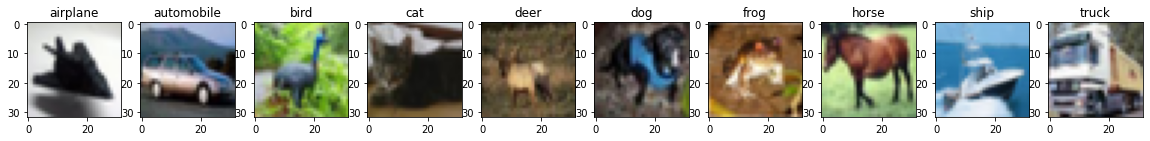

In [6]:
# Plot one sample from each class
fig, ax = plt.subplots(ncols=K, figsize=(20,5))
for i in range(K):
  idx = np.where(y_train == i)[0][0]
  x = x_train[idx,:,:,0] if x_train.shape[3] == 1 else x_train[idx,:,:]
  ax[i].imshow(x, cmap='gray');
  ax[i].set_title(labels[y_train[idx]]);

### Util: plot_confusion_matrix()

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(model, x, y, labels,
                          normalize=False,
                          n_pick=0,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  Missclassified examples are shown if `n_pick`>0.
  """
  y_ = model.predict(x).argmax(axis=1)
  cm = confusion_matrix(y_test, y_)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')
  #print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  K = len(labels)
  classes = list(range(K))
  tick_marks = np.arange(K)
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

  # Show some misclassified examples
  misclassified = np.where(y_ != y)[0]
  for _ in range(n_pick):
    print()
    i = np.random.choice(misclassified)
    plt.imshow(x[i], cmap='gray')
    plt.title(f'True: {labels[y[i]]}. Predicted: {labels[y_[i]]}');
    plt.show()

### Model with GlobalMaxPool layer

In [ ]:
from tensorflow.keras.layers import Input, Rescaling, Conv2D, MaxPool2D, BatchNormalization, GlobalMaxPool2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

i = Input(shape=shape); x=i
x = Rescaling(1./250.)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
x = MaxPool2D(2)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
x = MaxPool2D(2)(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
x = GlobalMaxPool2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(K)(x)
model = Model(i, x)

model.summary()

In [ ]:
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20)

In [ ]:
# Plot loss and accuracy per epoch
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(r.history['loss'], label='loss')
ax[0].plot(r.history['val_loss'], label='val_loss')
ax[0].set_title('loss')
ax[0].legend()
ax[1].plot(r.history['accuracy'], label='acc')
ax[1].plot(r.history['val_accuracy'], label='val_acc')
ax[1].set_title('accuracy')
ax[1].legend();

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(model, x_test, y_test, labels, n_pick=2)

### Model with Flatten layer

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy

i = Input(shape=shape); x=i
x = Rescaling(1./250.)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
x = MaxPool2D(2)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
x = MaxPool2D(2)(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x); x = BatchNormalization()(x)
x = Flatten()(x)  # Replacing GlobalMaxPool2D. Much bigger model!
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(K)(x)
model2 = Model(i, x)

model2.summary()

In [ ]:
model2.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

r2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20)

In [ ]:
# Plot loss and accuracy per epoch
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(r2.history['loss'], label='loss')
ax[0].plot(r2.history['val_loss'], label='val_loss')
ax[0].set_title('loss')
ax[0].legend()
ax[1].plot(r2.history['accuracy'], label='acc')
ax[1].plot(r2.history['val_accuracy'], label='val_acc')
ax[1].set_title('accuracy')
ax[1].legend();

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(model2, x_test, y_test, labels, n_pick=2)

### Data augmentation

In [ ]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Clone first model with newly instantiated weights
model3 = clone_model(model)

# We need to recompile the cloned model
model3.compile(
    loss=SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

# Instantiate a generator for data augmentation
train_generator = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
    ).flow(x_train, y_train, batch_size=32)

# Alternatively: Data augmentation layer to add just after the input layer
#data_augmentation = tf.keras.Sequential([
#  tf.keras.layers.RandomFlip('horizontal'),
#  tf.keras.layers.RandomTranslation(0.1, 0.1),
#  #tf.keras.layers.RandomRotation(0.1)
#])

# Fit with the generator
r3 = model3.fit(train_generator, validation_data=(x_test, y_test), epochs=20)

In [ ]:
# Plot loss and accuracy per epoch
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(r3.history['loss'], label='loss')
ax[0].plot(r3.history['val_loss'], label='val_loss')
ax[0].set_title('loss')
ax[0].legend()
ax[1].plot(r3.history['accuracy'], label='acc')
ax[1].plot(r3.history['val_accuracy'], label='val_acc')
ax[1].set_title('accuracy')
ax[1].legend();

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(model3, x_test, y_test, labels, n_pick=2)

### Transfer learning: MobileNet

Tutorial on transfer learning with MobileNet:
https://www.tensorflow.org/tutorials/images/transfer_learning

Try also: tf.keras.applications.vgg19.VGG19

In [8]:
# Create the base model from the pre-trained model MobileNetV2
target_shape = (96, 96)  # we choose the smallest available size of the pretrained model
colors = x_train.shape[-1]
base_model = tf.keras.applications.MobileNetV2(
  input_shape=target_shape + (colors,),
  weights='imagenet',
  include_top=False,  # drop the last Dense layer
  pooling='avg')  # include a final GlobalAveragePooling2D() layer
# Set the pretrained model as non trainable to freeze its weights
base_model.trainable = False

# Layer to convert input images to the expected format: pixel range [-1,+1]
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Upscale layer required to go from 32x32 to 96x96 pixels 
class Upscale(tf.keras.layers.Layer):
  def __init__(self, shape):
    super(Upscale, self).__init__()
    self.shape = shape
  def call(self, inputs):
    return tf.image.resize_with_pad(inputs, self.shape[0], self.shape[1])
# Alternatively, one could simply use a Lambda layer, but it is not seriazable (model not portable)
#Upscale = lambda shape: tf.keras.layers.Lambda(lambda x: tf.image.resize_with_pad(x, shape[0], shape[1]))

# Data augmentation layer to rotate and flip
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomTranslation(0.1, 0.1),
  #tf.keras.layers.RandomRotation(0.1),
], name='data_augmentation')

# This feature extractor converts each image into a 1280 block of features.
D = base_model.layers[-1].output_shape
print(f'Output features: {D}')

9406464/9406464 [==============================] - 0s 0us/step
Output features: (None, 1280)


In [9]:
# We combine data augmentation + MobileNet + final classification layer
i = tf.keras.Input(shape=shape); x=i
x = data_augmentation(x)
x = preprocess_input(x)
x = Upscale(target_shape)(x) 
x = base_model(x, training=False)  # freeze the BatchNormalization layers
#x = tf.keras.layers.Dropout(0.2)(x)  # input is already low res!
x = tf.keras.layers.Dense(K)(x)
model4 = tf.keras.Model(i, x)

model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 data_augmentation (Sequenti  (None, 32, 32, 3)        0         
 al)                                                             
                                                                 
 tf.math.truediv (TFOpLambda  (None, 32, 32, 3)        0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 32, 32, 3)        0         
 a)                                                              
                                                                 
 upscale (Upscale)           (None, 96, 96, 3)         0         
                                                             

In [10]:
base_learning_rate = 0.001
model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

r4 = model4.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20)

Epoch 1/20


 527/1563 [=========>....................] - ETA: 3:37 - loss: 0.8364 - accuracy: 0.7127

KeyboardInterrupt: ignored

In [ ]:
# Plot loss and accuracy per epoch
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(r4.history['loss'], label='loss')
ax[0].plot(r4.history['val_loss'], label='val_loss')
ax[0].set_title('loss')
ax[0].legend()
ax[1].plot(r4.history['accuracy'], label='acc')
ax[1].plot(r4.history['val_accuracy'], label='val_acc')
ax[1].set_title('accuracy')
ax[1].legend();

In [ ]:
from numpy.random import normal
# Plot confusion matrix
plot_confusion_matrix(model4, x_test, y_test, labels, n_pick=2)